In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
data_path = "./data/"
data_freq = "d"

In [47]:
df = pd.read_csv(data_path + "simple_va_trains.csv", sep=";", parse_dates=["DATE"])
transporteurs = ['Lyria', 'OUIGO', 'TER', 'TGV', 'intercite']
end_train_date = datetime(2018, 4, 30)
nb_days_pred = 90

# Préparation des données

In [48]:
df["NB_TRAINS"].fillna(0, inplace=True)
df.sort_values(by=["transporteur", "DATE"], inplace=True)
df = df[df["DATE"] < datetime(2019, 7, 1)]
df.index = df["DATE"]

df_dict = {}

for transporteur in transporteurs:
    df_dict[transporteur] = df[df["transporteur"]==transporteur].copy()
    df_dict[transporteur] = df_dict[transporteur].reindex(
        pd.date_range(start=df["DATE"].min(), end=df["DATE"].max())).drop(["DATE", "transporteur"], axis=1)
    df_dict[transporteur]["NB_TRAINS"] = df_dict[transporteur]["NB_TRAINS"].fillna(0)
df_dict["TGV"].head(3)

,VA,NB_TRAINS
2015-01-01,259.179478,549.0
2015-01-02,550.912647,760.0
2015-01-03,608.426338,789.0


# Entraînement de DeepAR

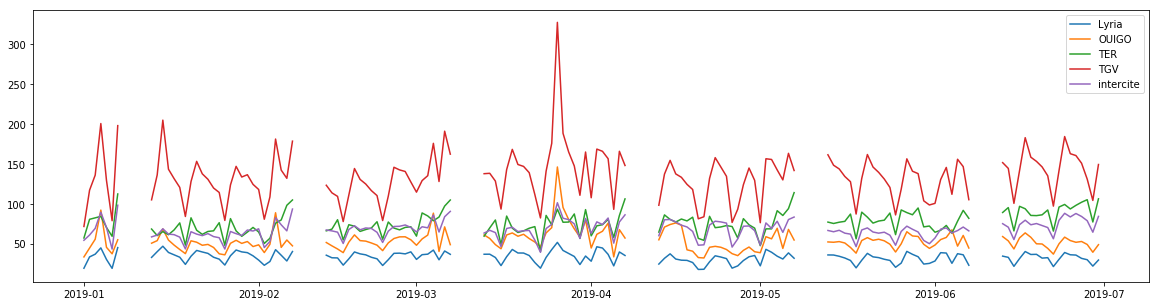

In [50]:
plt.figure(1, figsize=(20, 5))
for transporteur in ['Lyria', 'OUIGO', 'TER', "TGV", 'intercite']:
    df_trans = df_dict[transporteur].copy()
    df_trans = df_trans[df_trans.index >= datetime(2019, 1, 1)]
    if transporteur == "TGV":
        df_trans["VA"] = df_trans["VA"] / 5
    plt.plot(df_trans.index, df_trans["VA"], label=transporteur)
    plt.legend()
plt.show()

In [78]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, transporteurs_list, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_days_pred,
                                trainer=Trainer(epochs=8, learning_rate = 0.001,
                                                learning_rate_decay_factor=0.01, patience=3),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:end_train_date],
             "feat_dynamic_real": df_dict[transporteur][feat_dynamic_cols][:end_train_date]
             }
            for transporteur in transporteurs],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:end_train_date]
             }
            for transporteur in transporteurs],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, transporteurs_list, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:test_date + timedelta(days=90)],
             "feat_dynamic_real": df_dict[transporteur][feat_dynamic_cols][:test_date + timedelta(days=90)]
             }
            for transporteur in transporteurs_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": transporteur,
                "start": df_dict[transporteur].index[0],
              "target": df_dict[transporteur].VA[:test_date + timedelta(days=90)],
             }
            for transporteur in transporteurs_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots):
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        results_mean = forecast.mean
        ground_truth = df_dict[forecast.item_id].VA[test_date + timedelta(days=1):test_date + timedelta(days=90)].values
        #import pdb; pdb.set_trace()
        gt_non_nan = np.extract(~pd.isnull(ground_truth), ground_truth)
        results_non_nan = np.extract(~pd.isnull(ground_truth), results_mean)
        MAE = np.mean(np.apply_along_axis(abs, 0, (gt_non_nan - results_non_nan) / gt_non_nan))
        plt.title(forecast.item_id + " MAE:{}%".format(str(round(100*MAE, 1))))
        plt.show()

# Test

In [52]:
transporteurs_list = ["TGV"]

tgv_predictor = train_predictor(df_dict, end_train_date, transporteurs_list, feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.82it/s, avg_epoch_loss=4.26]
INFO:root:Epoch[0] Elapsed time 13.097 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.264587
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  2.96it/s, avg_epoch_loss=3.78]
INFO:root:Epoch[1] Elapsed time 16.870 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.778189
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.25it/s, avg_epoch_loss=3.64]
INFO:root:Epoch[2] Elapsed time 15.392 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.638847
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.11it/s, avg_epoch_loss=3.51]
INFO:root:Epoch[3] Elapsed time 16.108 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.512856
INFO:root:Epoch[4]

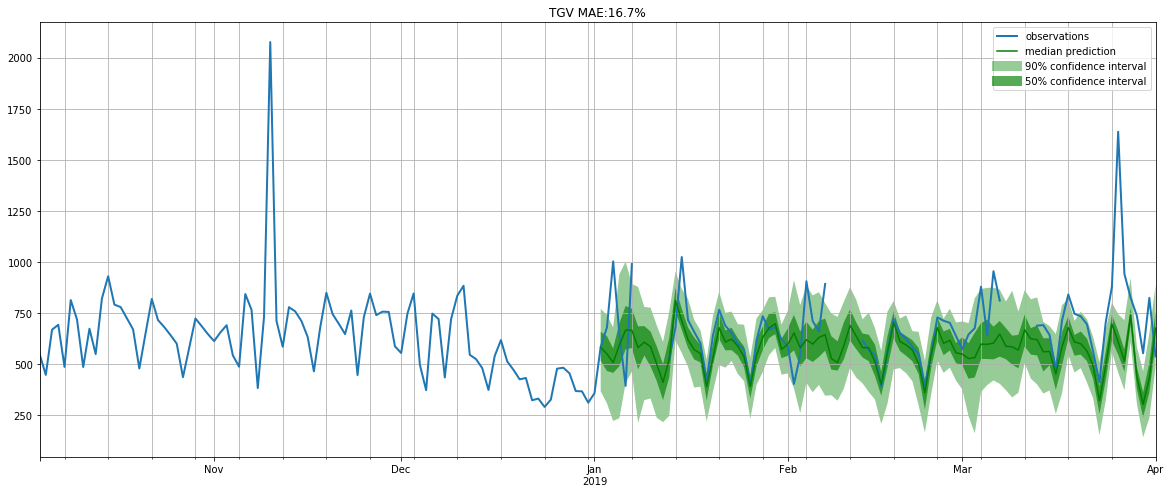

In [76]:
test_date = datetime(2019, 1, 1)
forecasts, tss = make_predictions(tgv_predictor, df_dict, test_date, transporteurs_list)
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_days_pred, num_plots=1)

In [77]:
transporteurs_list = transporteurs

all_trans_predictor = train_predictor(df_dict, end_train_date, transporteurs_list, feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.84it/s, avg_epoch_loss=4.21]
INFO:root:Epoch[0] Elapsed time 13.024 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.211496
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:13<00:00,  3.59it/s, avg_epoch_loss=3.72]
INFO:root:Epoch[1] Elapsed time 13.922 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.724646
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.32it/s, avg_epoch_loss=3.6] 
INFO:root:Epoch[2] Elapsed time 15.051 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.601375
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.32it/s, avg_epoch_loss=3.49]
INFO:root:Epoch[3] Elapsed time 15.063 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.491884
INFO:root:Epoch[4]

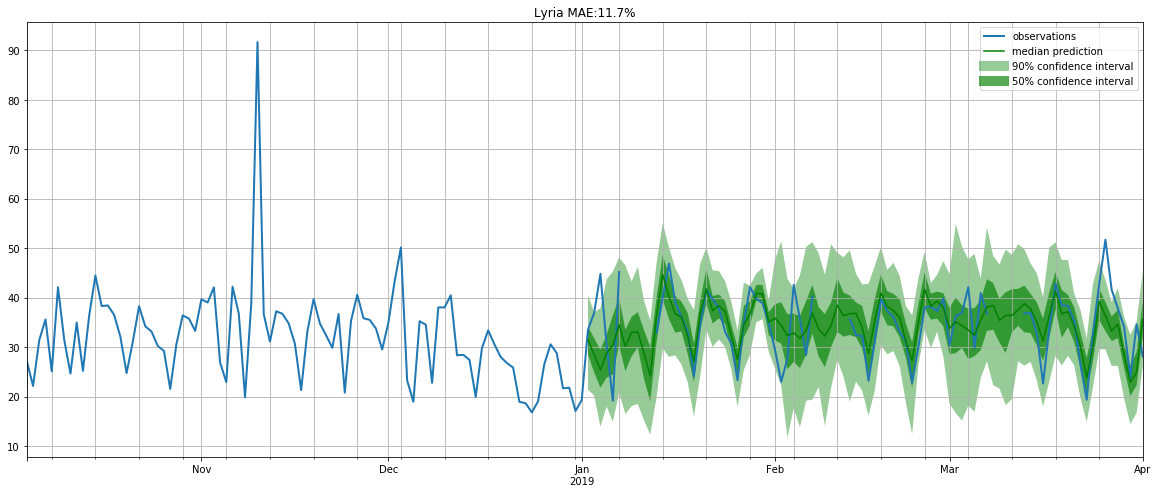

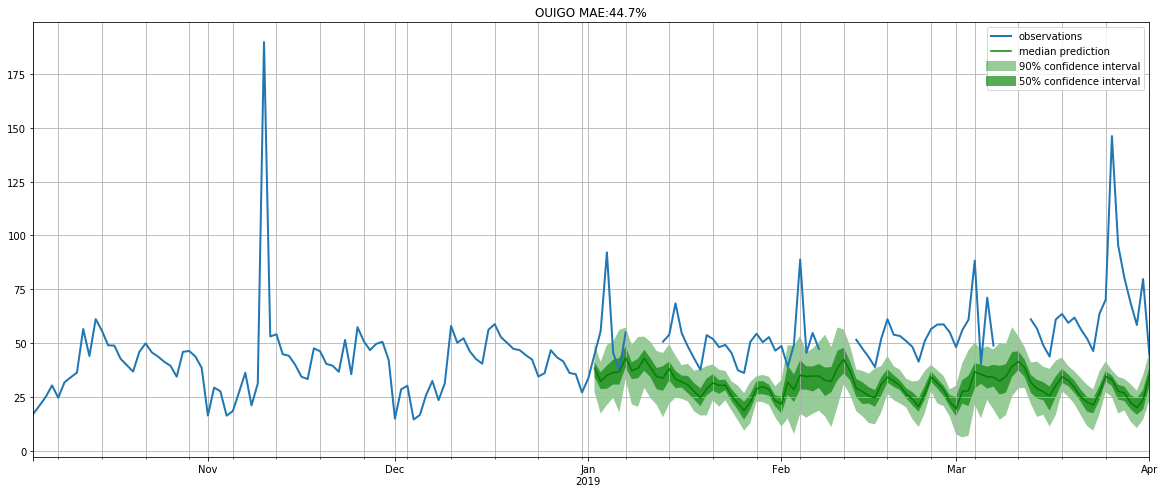

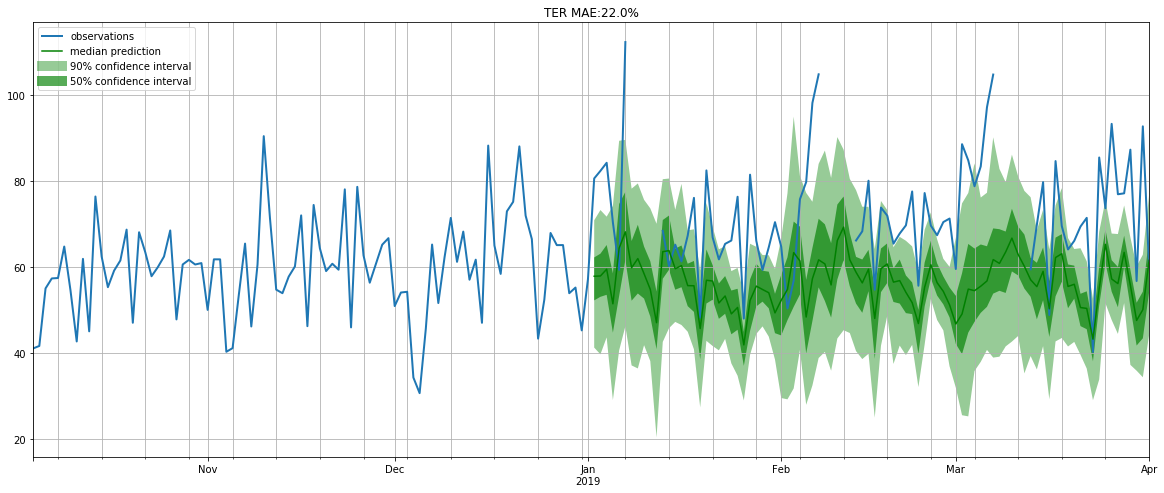

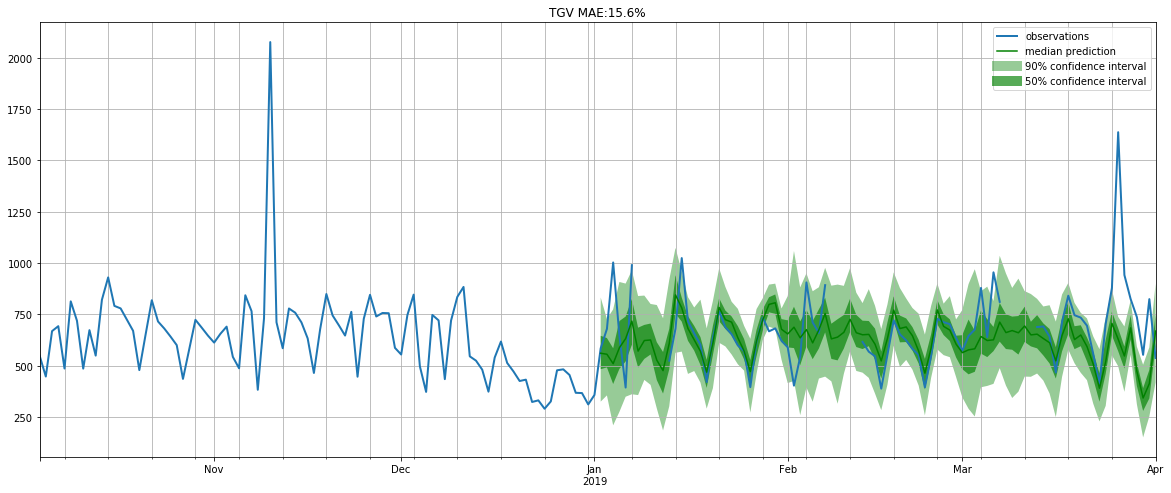

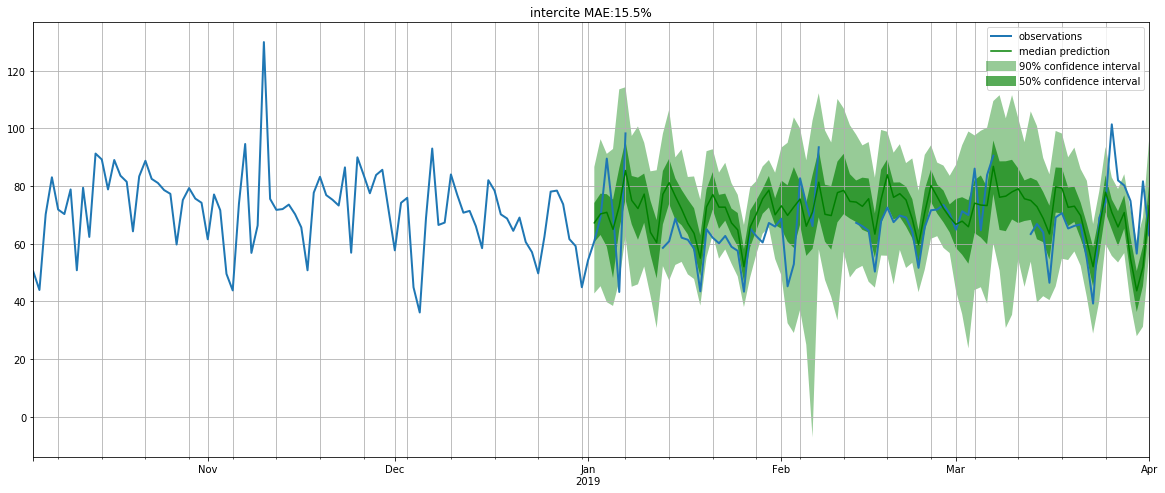

In [79]:
test_date = datetime(2019, 1, 1)
forecasts, tss = make_predictions(all_trans_predictor, df_dict, test_date, transporteurs_list)
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_days_pred, num_plots=1)